In [299]:
# load libaries
import os
import SimpleITK as sitk
from skimage.transform import radon, iradon
from scipy.ndimage import gaussian_filter
import numpy as np

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

import torch
import torch.nn as nn
from torch.optim import Adam
from scipy.ndimage import rotate

import cv2
from skimage.restoration import denoise_tv_chambolle

#Import the DIP repository, make sure to clone https://github.com/DmitryUlyanov/deep-image-prior
import sys
sys.path.append('C:/Users/ester/deep-image-prior')
from models import skip

In [300]:
import numpy
print(numpy.__version__)

1.24.4


In [301]:
# Helper Functions

def generate_sinogram_2d(image_2d, angles):
    """
    Generate a 2D sinogram using Radon transform and ensure that the area outside the circle is zero.
    :param image_2d: 2D NumPy array
    :param angles: List of projection angles (degrees)
    :return: 2D sinogram array
    """
    # Get image dimensions
    rows, cols = image_2d.shape
    # Calculate the radius of the circle
    radius = min(rows, cols) // 2
    # Create a mask to zero out areas outside the circle
    Y, X = np.ogrid[:rows, :cols]
    center_y, center_x = rows / 2, cols / 2
    mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
    image_masked = image_2d * mask
    # Generate sinogram
    sinogram = radon(image_masked, theta=angles, circle=True)
    return sinogram

def add_poisson_noise(sinogram, scale=1e4):
    """
    Add Poisson noise to a sinogram image.

    :param sinogram: 2D NumPy array representing the sinogram (non-negative).
    :param scale: A scaling factor to simulate photon counts. 
                  Larger scale -> higher counts -> relatively lower noise.
    :return: 2D NumPy array (float) with added Poisson noise.
    """
    # Ensure there are no negative values (Poisson noise requires non-negative input)
    sinogram_clipped = np.clip(sinogram, 0, None)
    
    # Scale up the intensity values to approximate "photon counts"
    sinogram_scaled = sinogram_clipped * scale
    
    # Generate Poisson noise (random photon counts)
    sinogram_noisy_scaled = np.random.poisson(sinogram_scaled).astype(np.float32)
    
    # Scale back down to the original magnitude
    sinogram_noisy = sinogram_noisy_scaled / scale
    
    return sinogram_noisy

def backproject(sinogram, angles):
    """
    Backprojection using the inverse Radon transform (FBP substitute).
    """
    reconstructed = np.zeros((sinogram.shape[1], sinogram.shape[1]))
    for i, angle in enumerate(angles):
        rotated_projection = rotate(np.tile(sinogram[i], (sinogram.shape[1], 1)).T, -angle, reshape=False)
        reconstructed += rotated_projection
    return reconstructed / len(angles)

def generate_sinogram(image, num_angles=180):
    angles = np.linspace(0, 180, num_angles, endpoint=False)
    sinogram = np.array([np.sum(rotate(image, angle, reshape=False), axis=0) for angle in angles])
    return sinogram, angles

def MLEM_reconstruction(sinogram, angles, num_iterations=50):
    """
    Perform MLEM reconstruction from a sinogram.

    Parameters:
    - sinogram: 2D numpy array representing the sinogram (angles x detector pixels).
    - angles: List of angles (degrees) corresponding to the sinogram.
    - num_iterations: Number of iterations for the reconstruction.

    Returns:
    - reconstructed: 2D numpy array, reconstructed image after MLEM iterations.
    """
    # Initialize the image with ones
    image_shape = (sinogram.shape[1], sinogram.shape[1])  # Square image
    reconstructed = np.ones(image_shape, dtype=np.float32)

    # Small constant to avoid division by zero
    epsilon = 1e-6

    for iteration in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Ensure matching shapes for division
        if forward_projection.shape != sinogram.shape:
            forward_projection = forward_projection[: sinogram.shape[0], :]

        # Compute the ratio
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image
        reconstructed *= back_projection

        # Regularization to ensure non-negative image
        reconstructed = np.maximum(reconstructed, 0)

        # Debugging/logging iteration progress
        # print(f"MLEM Iteration {iteration + 1}/{num_iterations} complete.")

    return reconstructed

In [302]:
# DIP Regularization
def DIP_regularization(image, num_iterations=1000): # can reduce?  #change from 500 to 100
    """
    Apply DIP-based regularization to the image using the CPU.
    """
    input_depth = 1
    device = torch.device("cpu")  # Explicitly set the device to CPU


    # Define the DIP network and move it to CPU
    net = skip(
        input_depth, 1,
        num_channels_down=[16, 32, 64, 128, 128],
        num_channels_up=[16, 32, 64, 128, 128],
        num_channels_skip=[4, 4, 4, 4, 4],
        upsample_mode='bilinear',
        need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU'
    ).to(device)


    # Input to DIP (random noise) on CPU
    input_noise = torch.randn(1, input_depth, image.shape[0], image.shape[1]).to(device)


    # Define optimizer and loss
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    mse_loss = torch.nn.MSELoss()


    # Convert the image to a PyTorch tensor on CPU
    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)


    # DIP optimization loop
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = net(input_noise)
        loss = mse_loss(output, image_tensor)
        loss.backward()
        optimizer.step()


    # Convert the output back to a NumPy array for visualization
    output_image = output.detach().cpu().squeeze().numpy()
    return output_image

In [303]:
# NR1 KEM Implementation 
# use a simple gaussian kernel 

def KEM_model(sinogram, initial_shape, angles, sigma=0.8, num_iterations=100, apply_kernel_every=10): #added , apply_kernel_every=2
    """
    Perform Kinetic Equation Modeling (KEM) refinement using a Gaussian kernel.

    Parameters:
    - sinogram: 2D numpy array representing the PET sinogram.
    - initial_image: 2D numpy array, initial guess for the reconstructed image.
    - angles: List of angles used in the Radon transform (degrees).
    - sigma: Standard deviation for the Gaussian kernel.
    - num_iterations: Number of iterations for the KEM process.

    Returns:
    - reconstructed: 2D numpy array, refined image after KEM iterations.
    """
    # Initialize the image to all ones
    # Initialize the reconstructed image
    image_shape = initial_shape.shape                                       
    reconstructed = np.ones(image_shape, dtype=np.float32)
    
    # Generate a Gaussian kernel for refinement
    #kernel = gaussian_filter(np.ones_like(reconstructed), sigma=sigma)       #commented this away

    # Small constant to avoid division by zero
    epsilon = 1e-8

    for i in range(num_iterations):
        # E-Step: Forward projection
        forward_projection = radon(reconstructed, theta=angles, circle=True)

        # Compute the ratio between the measured and projected data
        ratio = sinogram / (forward_projection + epsilon)

        # M-Step: Backprojection of the ratio
        back_projection = iradon(ratio, theta=angles, filter_name=None, circle=True)

        # Update the reconstructed image using the kernel
        reconstructed *= back_projection        #removed * kernel

         # Apply Gaussian kernel every 'apply_kernel_every' iterations
        if i % apply_kernel_every == 0 and sigma > 0:  
            reconstructed = gaussian_filter(reconstructed, sigma=sigma) #cv2.bilateralFilter(reconstructed, d=5, sigmaColor=25, sigmaSpace=25)
            


        # Regularization: Ensure non-negative values
        reconstructed = np.maximum(reconstructed, 0)

        # Debugging/logging iteration progress
        #print(f"KEM Iteration {i + 1}/{num_iterations} complete.")

    return reconstructed

In [304]:
## Dicom reader
def load_dicom_series(folder_path):
    """
    Load a DICOM series from the specified folder and return a SimpleITK image.
    """
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    if not dicom_names:
        raise ValueError(f"No DICOM files found in {folder_path}")
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def normalize_image(image):
    """
    Normalize the image to [0,1].
    """
    img_array = sitk.GetArrayFromImage(image).astype(np.float32)
    img_min = np.min(img_array)
    img_max = np.max(img_array)
    if img_max - img_min < 1e-5:
        return np.zeros_like(img_array)
    else:
        return (img_array - img_min) / (img_max - img_min)

In [305]:
## Image registration
def register_pet_ct(ct_image, pet_image, mode="upsample_PET"):
    """
    Register PET image to CT image space.
    mode: Select registration mode, "upsample_PET" to upsample PET to CT space,
          "downsample_CT" to downsample CT to PET space.
    """
    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()

    # Set multi-resolution pyramid strategy
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Set registration metric
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # Set transformation type (rigid transformation)
    initial_transform = sitk.CenteredTransformInitializer(
        ct_image,
        pet_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )

    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Set optimizer
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0,
                                                      numberOfIterations=100,
                                                      convergenceMinimumValue=1e-6,
                                                      convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Set interpolation method
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Perform registration
    #print("\nStarting registration...")
    try:
        final_transform = registration_method.Execute(sitk.Cast(ct_image, sitk.sitkFloat32),
                                                      sitk.Cast(pet_image, sitk.sitkFloat32))

        #print("\nRegistration completed.")
        print("Optimizer Converged:", registration_method.GetOptimizerStopConditionDescription())
        print("Final Metric Value:", registration_method.GetMetricValue())
    except Exception as e:
        print(f"\nRegistration failed: {e}")
        raise e

    resampler = sitk.ResampleImageFilter()
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(0)
    resampler.SetTransform(final_transform)

    if mode == "upsample_PET":
        resampler.SetReferenceImage(ct_image)
        #print("\nResampling PET image to CT space...")
        pet_resampled = resampler.Execute(pet_image)
        print("Resampling completed.")
        return ct_image, pet_resampled

    elif mode == "downsample_CT":
        resampler.SetReferenceImage(pet_image)
        #print("\nResampling CT image to PET space...")
        ct_resampled = resampler.Execute(ct_image)
        print("Resampling completed.")
        return ct_resampled, pet_image

    else:
        raise ValueError("Invalid mode selection, mode should be 'upsample_PET' or 'downsample_CT'")

In [306]:
# Design for Bowsher prior Filter 

def apply_bayesian_filter(image_2d, sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    """
    Apply the Bowsher-like Bayesian kernel filter on the 2D image.
    
    Parameters:
    - image_2d: 2D numpy array of the image to be filtered.
    - sigma: Standard deviation for Gaussian filtering (for gradient calculation).
    - zeta, rho, alpha: Parameters for the Bowsher-like prior kernel design.
    
    Returns:
    - filtered_image: Image after applying the Bayesian filter.
    """
    # Compute the Bayesian kernel (Bowsher-like prior)
    kernel = compute_bowsher_kernel_2d(image_2d, zeta=zeta, rho=rho, alpha=alpha)

    # Apply the kernel to the image
    filtered_image = image_2d * kernel

    return filtered_image

# Example Kernel computation functions for Bayesian method
def compute_kernel_2d(ct_2d, sigma=1.0):
    """
    Compute a 2D kernel function based on the CT image, preserving edges using gradient information.
    :param ct_2d: 2D NumPy array
    :param sigma: Standard deviation for Gaussian filtering
    :return: 2D kernel array
    """
    # Compute the gradient of the CT image
    gradient_x = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_y = gaussian_filter(ct_2d, sigma=sigma, order=1, mode='nearest')
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

    # Design a bilateral kernel, assigning lower weights to edges
    kernel = np.exp(- (gradient_magnitude ** 2))
    return kernel

def psi(u, zeta=0.5, rho=0.01):
    """
    Smooth weighting function as described in the Bowsher-like prior.
    psi(u) = (1/pi) * arctan((zeta - u) / rho) + 0.5
    
    Parameters
    ----------
    u : float or np.ndarray
        The normalized intensity difference.
    zeta : float
        Controls the 'threshold' position in the arctan function.
    rho : float
        Controls the smoothness (slope) in the transition.
    
    Returns
    -------
    float or np.ndarray
        The weight in [0,1] range after applying the arctan-based mapping.
    """
    return (np.arctan((zeta - u) / rho) / np.pi) + 0.5

def Tq_linear(value):
    """
    A default linear operator Tq, which is the identity mapping in this case.
    
    Parameters
    ----------
    value : float or np.ndarray
        The intensity value(s) to be transformed.
    
    Returns
    -------
    float or np.ndarray
        The same value(s), as we apply the identity transformation.
    """
    return value


def compute_bowsher_kernel_2d(
    ct_image_2d, 
    zeta=0.5, 
    rho=0.01, 
    Tq_func=Tq_linear, 
    epsilon=1e-6,
    alpha = 0.001
):
    """
    Compute 2D Bowsher-like weights (anatomical kernel) for each pixel and its 8 neighbors.
    
    Parameters
    ----------
    ct_image_2d : np.ndarray
        2D array of CT intensities, shape (H, W).
    zeta : float
        Parameter in psi(u), controlling the arctan shift.
    rho : float
        Parameter in psi(u), controlling the smoothness.
    Tq_func : callable
        A function representing the linear operator Tq, default is identity.
        You can replace it with your custom transform if needed.
    epsilon : float
        A small value to avoid division by zero in denominators.
    
    Returns
    -------
    weights_2d : np.ndarray
        A float32 array of shape (H, W, 8). 
        For each pixel (y,x), the last dimension contains the 8 neighbor weights.
    """

    # Offsets for the 8 neighbors in (dy, dx)
    neighbor_offsets = [
        (-1, -1), (-1, 0), (-1, 1),
        ( 0, -1),          ( 0, 1),
        ( 1, -1), ( 1, 0), ( 1, 1)
    ]
    
    H, W = ct_image_2d.shape
    weights_2d = np.zeros((H, W, len(neighbor_offsets)), dtype=np.float32)

    # Pre-compute Tq for the entire image to avoid repeated calls
    transformed_ct = Tq_func(ct_image_2d)

    # For each pixel, we need M_j = max|Tq(mu_j) - Tq(mu_k)| over neighbors
    # We'll store that in an array for quick access
    M_array = np.zeros((H, W), dtype=np.float32)

    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            diffs = []
            for dy, dx in neighbor_offsets:
                ny, nx = y + dy, x + dx
                if 0 <= ny < H and 0 <= nx < W:
                    neighbor_val = transformed_ct[ny, nx]
                    diffs.append(abs(central_val - neighbor_val))
            if len(diffs) > 0:
                M_array[y, x] = max(diffs)
            else:
                M_array[y, x] = 0.0

    # Compute the actual weights for each neighbor
    for y in range(H):
        for x in range(W):
            central_val = transformed_ct[y, x]
            Mj = M_array[y, x]
            
            for n_idx, (dy, dx) in enumerate(neighbor_offsets):
                ny, nx = y + dy, x + dx
                if not (0 <= ny < H and 0 <= nx < W):
                    # Out of bounds, weight = 0
                    weights_2d[y, x, n_idx] = 0.0
                    continue
                
                neighbor_val = transformed_ct[ny, nx]
                Mk = M_array[ny, nx]
                
                denom = (Mj + Mk) / 2.0
                denom = denom if denom > epsilon else epsilon
                
                diff = abs(central_val - neighbor_val)
                u_jk = diff / denom
                
                w_jk = psi(u_jk, zeta=zeta, rho=rho)
                weights_2d[y, x, n_idx] = w_jk

    kernel = np.sum(weights_2d, axis=-1)
    kernel = np.exp(alpha * kernel) # exp
    #kernel = 1.0 / (1.0 + np.exp(-alpha * kernel)) #sigmoid
    
    return kernel

In [307]:
## Hybrid Model Nr 2 KEM + DIP with different kernel

def project(image, angles):
    # Forward projection function (e.g., Radon transform)
    return radon(image, theta=angles, circle=True)

def backproject(sinogram, angles):
    # Backprojection function (e.g., filtered or unfiltered backprojection)
     return iradon(sinogram, theta=angles, circle=True)

def generate_perlin_noise(size):
    noise = PerlinNoise(octaves=4)  # Corrected: single integer
    perlin_map = [[noise([i/size[0], j/size[1]]) for j in range(size[1])] for i in range(size[0])]
    return torch.tensor(perlin_map, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape (1,1,H,W)



def apply_filter(image, method="bilateral", sigma=1.0, zeta=0.5, rho=0.01, alpha=0.001):
    """
    Parameters:
    - image: Torch tensor (grayscale, shape [H, W])
    - method: "bilateral" for bilateral filtering, "anisotropic" for anisotropic diffusion, "gaussian" for Gaussian filtering, "bayesian" for Bowsher-like prior.
    - sigma: Parameter controlling smoothing intensity.
    - zeta, rho, alpha: Parameters for Bayesian (Bowsher-like) kernel design.
    
    Returns:
    - filtered_image: Filtered image as a torch tensor.
    """
    image_np = image.detach().cpu().numpy()  # Use .detach() to remove gradients

    if method == "bilateral":
        # Bilateral filter (preserves edges while reducing noise)
        filtered_image = cv2.bilateralFilter(image_np.astype(np.float32), d=9, sigmaColor=sigma*50, sigmaSpace=sigma*50)
    
    elif method == "anisotropic":
        # Anisotropic diffusion (Total Variation denoising)
        filtered_image = denoise_tv_chambolle(image_np, weight=sigma)
    
    elif method == "gaussian":
        # Gaussian filter
        filtered_image = gaussian_filter(image_np, sigma=sigma)
    
    elif method == "bayesian":
        # Bayesian kernel (Bowsher-like prior)
        filtered_image = apply_bayesian_filter(image_np, sigma=sigma, zeta=zeta, rho=rho, alpha=alpha)
    
    else:
        raise ValueError("Invalid method. Choose 'bilateral', 'anisotropic', 'gaussian', or 'bayesian'.")

    return torch.tensor(filtered_image, dtype=torch.float32).to(image.device)


def total_variation_loss_version1(image):
    tv_h = torch.sum(torch.abs(image[:, :, 1:, :] - image[:, :, :-1, :]))
    tv_w = torch.sum(torch.abs(image[:, :, :, 1:] - image[:, :, :, :-1]))
    return tv_h + tv_w


def total_variation_loss_version2(img):
    diff1 = torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:])
    diff2 = torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :])
    return torch.sum(diff1) + torch.sum(diff2)



def KEM_step(image, sinogram, angles, kernel_size, sigma=1.0, filter_method="bilateral"):
    device = image.device

    # Step 1: Forward project the image (detach to prevent gradient issues)
    forward_projection = project(image.squeeze().detach().cpu().numpy(), angles)  
    forward_projection = torch.tensor(forward_projection, dtype=torch.float32).to(device)

    # Step 2: Compute correction term
    ratio = sinogram / (forward_projection + 1e-8)
    ratio = ratio.clamp(min=0, max=10)

    # Backproject the correction term
    back_projection = backproject(ratio.cpu().numpy(), angles)
    back_projection = torch.tensor(back_projection, dtype=torch.float32).to(device)

    # Step 3: Apply chosen filtering method
    smoothed_image = apply_filter(image.squeeze(), method=filter_method, sigma=sigma)
    if isinstance(smoothed_image, np.ndarray):  # If it's a NumPy array
        smoothed_image = torch.from_numpy(smoothed_image).float().to(device)
    else:  # If it's already a tensor
        smoothed_image = smoothed_image.clone().detach().to(device)

    # Step 4: Update image
    updated_image = smoothed_image * back_projection
    updated_image = updated_image / updated_image.max()

    return updated_image.unsqueeze(0).unsqueeze(0)

    

In [308]:
# Evaluation
def evaluate_reconstruction(ground_truth, reconstructed):
    """
    Evaluate reconstruction quality using MSE, PSNR, and SSIM.
    """
    #mse_val = mse(ground_truth, reconstructed)
    ssim_val = ssim(ground_truth, reconstructed, data_range=ground_truth.max() - ground_truth.min())
    #psnr_val = cv2.PSNR(ground_truth.astype(np.float32), reconstructed.astype(np.float32)) #20 * np.log10(ground_truth.max() / np.sqrt(mse_val))
    rmse_val = np.sqrt(mse(ground_truth, reconstructed))
    mse_val = np.mean((ground_truth - reconstructed) ** 2)
    psnr_val = 20 * np.log10(ground_truth.max() / np.sqrt(mse_val))
    return mse_val, psnr_val, ssim_val, rmse_val

In [309]:
# Load an example image
ct_folder_path = r"C:\Users\ester\Downloads\NIH\NIH\CT\CT_1.3.6.1.4.1.14519.5.2.1.7009.2403.192241118078441962132923230489"
pet_folder_path = r"C:\Users\ester\Downloads\NIH\NIH\CT\PT_1.3.6.1.4.1.14519.5.2.1.7009.2403.121694709831221676480030303736"

# Load images
print("Loading CT image...")
ct_image = load_dicom_series(ct_folder_path)
print("Loading PET image...")
pet_image = load_dicom_series(pet_folder_path)



# Print image information
def print_image_info(name, image):
    print(f"\n{name} Image Information:")
    print(f"  Size: {image.GetSize()}")
    print(f"  Spacing: {image.GetSpacing()}")
    print(f"  Origin: {image.GetOrigin()}")
    print(f"  Direction: {image.GetDirection()}")
    print(f"  Dimension: {image.GetDimension()}")

print_image_info("CT", ct_image)
print_image_info("PET", pet_image)

# Ensure both are 3D images
if ct_image.GetDimension() != 3 or pet_image.GetDimension() != 3:
    raise ValueError("Both CT and PET images must be 3D.")

# Ensure both are float32
ct_image = sitk.Cast(ct_image, sitk.sitkFloat32)
pet_image = sitk.Cast(pet_image, sitk.sitkFloat32)


#mode = "upsample_PET"
mode = "downsample_CT"
ct_image_resampled, pet_image_resampled = register_pet_ct(ct_image, pet_image, mode=mode)

# ================== 3) Select Middle Slice and Generate Sinogram ==================

# Select middle slice
ct_array = sitk.GetArrayFromImage(ct_image_resampled)  # shape: [slices, height, width]
pet_array = sitk.GetArrayFromImage(pet_image_resampled)  # shape: [slices, height, width]

middle_slice_idx = ct_array.shape[0] // 2
ct_slice = ct_array[middle_slice_idx, :, :]
pet_slice = pet_array[middle_slice_idx, :, :]

# Normalize
ct_norm = normalize_image(ct_image_resampled)
pet_norm = normalize_image(pet_image_resampled)
ct_slice_norm = ct_norm[middle_slice_idx, :, :]
pet_slice_norm = pet_norm[middle_slice_idx, :, :]
initial_kernel_size = ct_slice_norm

# Generate sinogram
angles = np.linspace(0., 180., max(ct_slice.shape), endpoint=False)
pet_sinogram = generate_sinogram_2d(pet_slice_norm, angles)
pet_sinogram = add_poisson_noise(pet_sinogram, scale=1) #change from 1e3 to 1 to increase noise





Loading CT image...
Loading PET image...

CT Image Information:
  Size: (512, 512, 307)
  Spacing: (0.9765625, 0.9765625, 2.5)
  Origin: (-249.51172, -460.51172, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3

PET Image Information:
  Size: (128, 128, 307)
  Spacing: (5.3067274, 5.3067274, 2.5)
  Origin: (-339.16485, -553.64165, -1007.0)
  Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
  Dimension: 3
Optimizer Converged: GradientDescentOptimizerv4Template: Convergence checker passed at iteration 30.
Final Metric Value: -0.35428078714341377
Resampling completed.


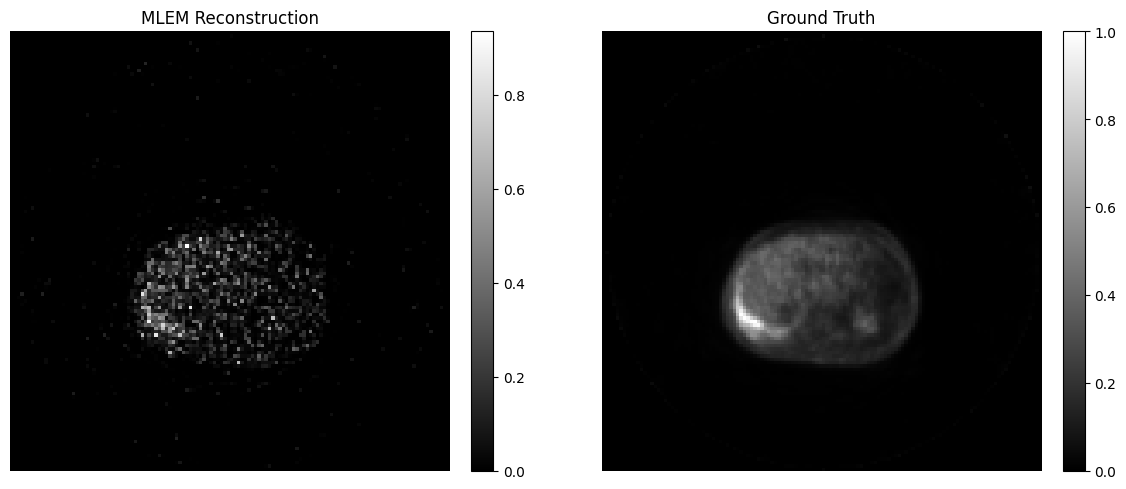

In [310]:
# MLEM Reconstruction for comparison
mlem_reconstructed = MLEM_reconstruction(pet_sinogram, angles)

pet_slice_norm = (pet_slice - np.min(pet_slice)) / (np.max(pet_slice) - np.min(pet_slice))
ground_truth = pet_slice_norm
ct_slice_norm =  (ct_slice - np.min(ct_slice)) / (np.max(ct_slice) - np.min(ct_slice))
ct_prior = ct_slice_norm

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  
im1 = axes[0].imshow(mlem_reconstructed, cmap='gray')  
axes[0].set_title("MLEM Reconstruction")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  
im2 = axes[1].imshow(ground_truth, cmap='gray')  
axes[1].set_title("Ground Truth")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  
plt.tight_layout()  
plt.show()

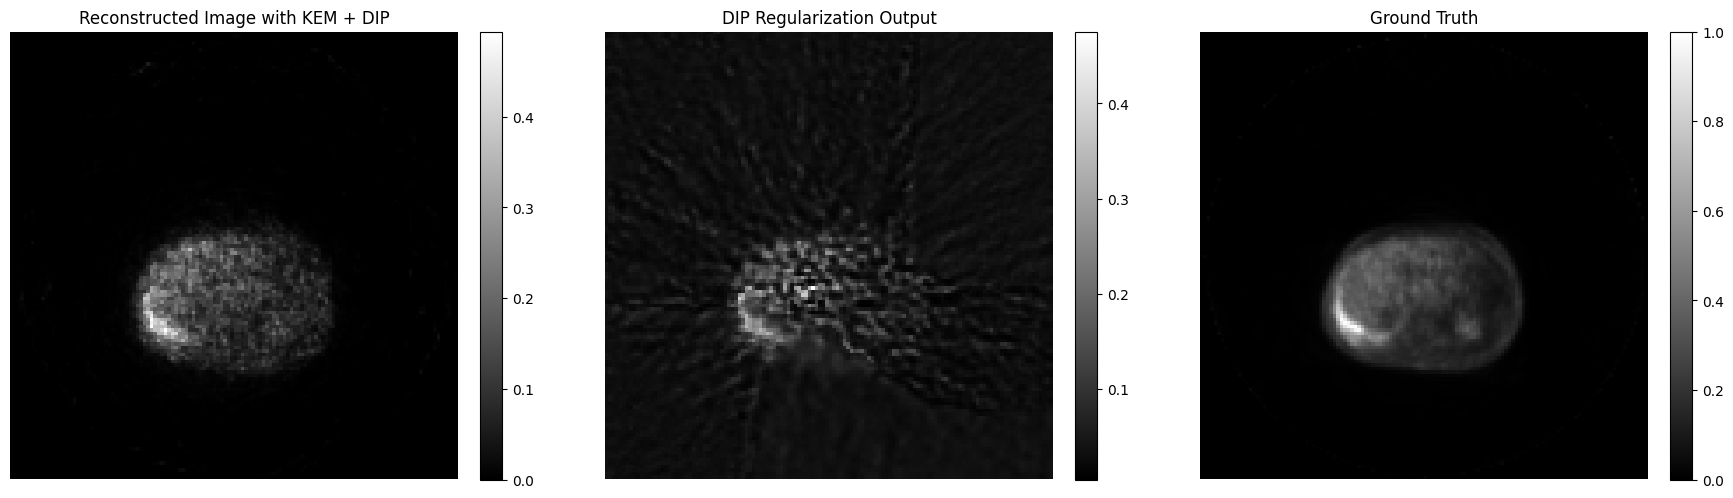

In [311]:
# Example usage of KEM and DIP
fbp_initial = backproject(pet_sinogram, angles)  # FBP or some other backprojection

# Now apply KEM with DIP regularization
image_shape = fbp_initial.shape  # Shape of the reconstructed image
kem_output = KEM_model(pet_sinogram, fbp_initial, angles, num_iterations=10)  # Pass fbp_initial instead of image_shape

# Get DIP regularization output
output_image= DIP_regularization(fbp_initial)  # Assuming DIP operates on fbp_initial

# Ground truth for comparison (assuming 'pet_slice_norm' contains the ground truth image)
ground_truth = pet_slice_norm

# Plotting KEM reconstruction, DIP output, and Ground truth
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  

# KEM reconstruction
im1 = axes[0].imshow(kem_output, cmap='gray')  
axes[0].set_title("Reconstructed Image with KEM + DIP")  
axes[0].axis('off')  
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)  

# DIP regularization output
im2 = axes[1].imshow(output_image, cmap='gray')  
axes[1].set_title("DIP Regularization Output")  
axes[1].axis('off')  
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)  

# Ground truth
im3 = axes[2].imshow(ground_truth, cmap='gray')  
axes[2].set_title("Ground Truth")  
axes[2].axis('off')  
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)  

plt.tight_layout()  
plt.show()




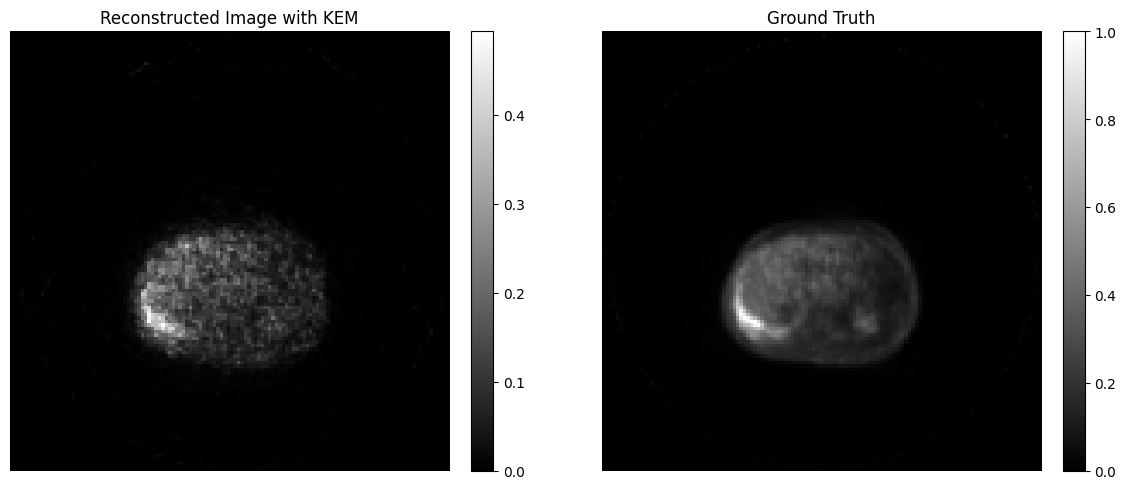

In [312]:
# Example usage of KEM
fbp_initial = backproject(pet_sinogram, angles)  # FBP or some other backprojection

# Apply KEM reconstruction
kem_output = KEM_model(pet_sinogram, fbp_initial, angles, num_iterations=10)

# Ground truth for comparison
ground_truth = pet_slice_norm

# Plotting KEM reconstruction and Ground truth
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# KEM reconstruction
im1 = axes[0].imshow(kem_output, cmap='gray')
axes[0].set_title("Reconstructed Image with KEM")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Ground truth
im2 = axes[1].imshow(ground_truth, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [313]:
# Evaluation of MLEM vs KEM + DIP reconstruction

metrics_mlem = evaluate_reconstruction(ground_truth, mlem_reconstructed)

print("MLEM Reconstruction Metrics:")
print(f"MSE: {metrics_mlem[0]:.4f}, PSNR: {metrics_mlem[1]:.2f}, SSIM: {metrics_mlem[2]:.4f}, RMSE: {metrics_mlem[3]:.4f}\n")

metrics_kemdip = evaluate_reconstruction(ground_truth, kem_output)

print("KEM + DIP Reconstruction Metrics:")
print(f"MSE: {metrics_kemdip[0]:.4f}, PSNR: {metrics_kemdip[1]:.2f}, SSIM: {metrics_kemdip[2]:.4f}, RMSE: {metrics_kemdip[3]:.4f}\n")

# SSIM = 1 → Perfect match with the reference image.
# SSIM > 0.9 → Excellent similarity, almost no perceptual difference.
# SSIM 0.7 - 0.9 → Good quality, but noticeable artifacts.
# SSIM 0.5 - 0.7 → Moderate degradation.
# SSIM < 0.5 → Significant structural differences and quality loss.



# MSE: lower is better
# PSNR: higher is better
# SSIM: higher is better
# RMSE: lower us better




MLEM Reconstruction Metrics:
MSE: 0.0040, PSNR: 23.97, SSIM: 0.8174, RMSE: 0.0633

KEM + DIP Reconstruction Metrics:
MSE: 0.0024, PSNR: 26.14, SSIM: 0.8902, RMSE: 0.0493



In [314]:
# MLEM Reconstruction Metrics:
# MSE: 0.0003, PSNR: 25.63, SSIM: 0.9592, RMSE: 0.0165

# KEM + DIP Reconstruction Metrics: (1) with sigma = 0.5 and every 5 iteration apply smoothness
# MSE: 0.0003, PSNR: 25.98, SSIM: 0.9420, RMSE: 0.0159 (SSIM just slightly lower, much better than previous!!! (in DIP))

# KEM + DIP Reconstruction Metrics: (2) with sigma = 1.0 and every 2 iteration apply smoothness
# MSE: 0.0002, PSNR: 26.07, SSIM: 0.9272, RMSE: 0.0157

# KEM + DIP Reconstruction Metrics: (3) sigma = 0.2 and every 2 interation
# MSE: 0.0003, PSNR: 25.99, SSIM: 0.9433, RMSE: 0.0158

# num of efery interation does not seem to influence too much, sigma = 0,8? to get higher SSIM ans lower MSE

# KEM + DIP Reconstruction Metrics: (4) sigma = 0.8 and every 2 iterations
# MSE: 0.0002, PSNR: 26.04, SSIM: 0.9318, RMSE: 0.0157

#KEM + DIP Reconstruction Metrics: (5) changed to other filter: biltaeral
#MSE: 0.0002, PSNR: 26.06, SSIM: 0.9262, RMSE: 0.

#KEM + DIP Reconstruction Metrics: (6) changing formula for psnr (unusually high value??)
#MSE: 0.0002, PSNR: 84.21, SSIM: 0.9257, RMSE: 0.0157

#KEM + DIP Reconstruction Metrics: (7) changes arguments for bilateral filtering in KEM (took 20 min! :( )
#MSE: 0.0002, PSNR: 84.21, SSIM: 0.9257, RMSE: 0.0157

#KEM + DIP Reconstruction Metrics: (8) changing back to gaussian filter with less iterations of dip 500 --> 200
#MSE: 0.0002, PSNR: 84.17, SSIM: 0.9319, RMSE: 0.0158

#KEM + DIP Reconstruction Metrics: (changing calculations for mse and psnr)
#MSE: 0.0024, PSNR: 26.25, SSIM: 0.9076, RMSE: 0.0487